<a href="https://colab.research.google.com/github/rrahul2203/Deep-learning-Computer-Vision/blob/main/VariationalAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import os 
import random 
import numpy as np

# Confirm GPU is available 
print("Number of GPU availables: ", len(tf.config.list_physical_devices('GPU')))

Number of GPU availables:  1


In [ ]:
SEED = 123456
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert y_train.shape == (60000,)
assert x_test.shape == (10000, 28, 28)
assert y_test.shape == (10000,)

4431872/4422102 [==============================] - 0s 0us/step


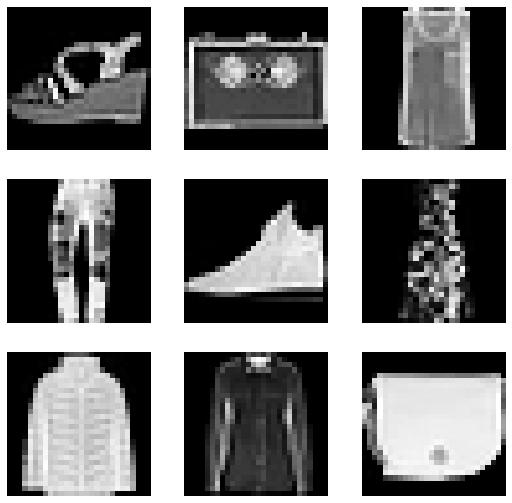

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,9))

random_samples = np.random.choice(60000, 9)

for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(x_train[random_samples[i]], cmap='Greys_r')
  plt.axis('off')

plt.show()

In [ ]:
dataset = np.concatenate([x_train, x_test], axis = 0)
print(dataset.shape)
dataset = np.expand_dims(dataset, -1).astype('float32')/255
print(dataset.shape)

(70000, 28, 28)
(70000, 28, 28, 1)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers


## Create a Sampling layer
class SamplingLayer(layers.Layer):
  """Reparameterization Trick z= mu + sigma*epsilon"""
  def call(self, inputs):
    zMean, zLogVar = inputs
    batch = tf.shape(zMean)[0]
    dim = tf.shape(zMean)[1]
    epsilon =tf.keras.backend.random_normal(shape=(batch, dim))
    return zMean + tf.exp(0.5*zLogVar)*epsilon

In [ ]:
def buildEncoder(latentDims, encoderInputs):
  # Given a batch of images the convolutional block extracts the features
  l1 = keras.models.Sequential([
      layers.Conv2D(128, 3, activation='relu', strides=2, padding='same'),
      layers.Conv2D(64,3, activation='relu', strides=2, padding='same'),
      layers.Flatten(),
      layers.Dense(256, activation='relu')
  ])

  # pass the inputs throught the convolutional block 
  x = l1(encoderInputs)

  # a dedicated layer to learn the mean in parallel
  zMean = layers.Dense(latentDims, name = "z_mean")(x)

  # a dedicated layer to learn the variance in parallel
  zlogVar = layers.Dense(latentDims, name = "z_log_var")(x)

  # now the reparametrization trick to find the z defined by mean and variance 
  z = SamplingLayer()([zMean, zlogVar])
  
  return keras.Model(encoderInputs, [zMean, zlogVar, z], name = "encoder")


# trigger the function to build the model
encoderInputs = keras.Input(shape=(28,28,1))
encoder = buildEncoder(2, encoderInputs)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential_3 (Sequential)      (None, 256)          878144      ['input_4[0][0]']                
                                                                                                  
 z_mean (Dense)                 (None, 2)            514         ['sequential_3[0][0]']           
                                                                                                  
 z_log_var (Dense)              (None, 2)            514         ['sequential_3[0][0]']           
                                                                                            

In [ ]:
def buildDecoder(latentInputs):

  l1 = keras.models.Sequential([
      layers.Dense(7*7*64, activation='relu', input_shape=(latentInputs.shape[1],)),
      layers.Reshape((7,7,64)),
      layers.Conv2DTranspose(128, 3, activation="relu", strides = 2, padding="same"),
      layers.Conv2DTranspose(64, 3, activation="relu", strides = 2, padding="same"),
      layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")
  ])

  return keras.Model(latentInputs, l1(latentInputs), name = "decoder")

# build the actual model
latentInputs = keras.Input(shape=(2,))
decoder = buildDecoder(latentInputs)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2)]               0         
                                                                 
 sequential_4 (Sequential)   (None, 28, 28, 1)         157633    
                                                                 
Total params: 157,633
Trainable params: 157,633
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Loss function
def reconstructionLoss(data, reconstructed):
  return tf.reduce_mean(
      tf.reduce_sum(
          keras.losses.binary_crossentropy(data, reconstructed),
          axis = (1,2)
      )
  )


def klDivergenceLoss(zMean, zLogVar):
  return tf.reduce_mean(
      tf.reduce_sum(
          -0.5 * (1+zLogVar - tf.square(zMean) - tf.exp(zLogVar)), 
          axis = 1
      )
  )


def calcTotalLoss(data, reconstructed, zMean, zLogVar):
  loss1 = reconstructionLoss(data, reconstructed)
  loss2 = klDivergenceLoss(zMean, zLogVar)
  klweight = 3.0
  return loss1, loss2, loss1 + klweight*loss2

In [ ]:
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder 
    self.decoder = decoder
    # register total loss as on observable metrics in the model training history
    self.totalLossTracker = keras.metrics.Mean(name = 'total_loss')
    self.ceLossTracker = keras.metrics.Mean(name='ce_loss')
    self.klLossTracker = keras.metrics.Mean(name='kl_loss')

  @property
  def metrics(self):
    return {
        self.totalLossTracker, 
        self.ceLossTracker,
        self.klLossTracker
    }

  def train_step(self, data):
    with tf.GradientTape() as tape:
      zMean, zLogVar, z = self.encoder(data)
      reconstructed = self.decoder(z)
      ceLoss, klLoss, totalLoss = calcTotalLoss(data, reconstructed, zMean, zLogVar)

    grads = tape.gradient(totalLoss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    # keep track of loss 
    self.totalLossTracker.update_state(totalLoss)
    self.ceLossTracker.update_state(ceLoss)
    self.klLossTracker.update_state(klLoss)

    # return the loss for history objects
    return {
        "total_loss": self.totalLossTracker.result(),
        "ce_loss" : self.ceLossTracker.result(),
        "kl_loss" : self.klLossTracker.result()
    }

In [ ]:
# Train the VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001))
history = vae.fit(dataset, epochs=50, batch_size = 128)

Epoch 1/50
547/547 [==============================] - 11s 19ms/step - total_loss: 265.7003 - ce_loss: 249.9910 - kl_loss: 5.2364
Epoch 2/50
547/547 [==============================] - 10s 17ms/step - total_loss: 265.6217 - ce_loss: 249.8705 - kl_loss: 5.2504
Epoch 3/50
547/547 [==============================] - 9s 17ms/step - total_loss: 265.4753 - ce_loss: 249.7245 - kl_loss: 5.2502
Epoch 4/50
547/547 [==============================] - 9s 17ms/step - total_loss: 265.4114 - ce_loss: 249.6413 - kl_loss: 5.2567
Epoch 5/50
547/547 [==============================] - 12s 21ms/step - total_loss: 265.3106 - ce_loss: 249.5117 - kl_loss: 5.2663
Epoch 6/50
547/547 [==============================] - 12s 21ms/step - total_loss: 265.2247 - ce_loss: 249.4272 - kl_loss: 5.2658
Epoch 7/50
547/547 [==============================] - 11s 20ms/step - total_loss: 265.1332 - ce_loss: 249.3208 - kl_loss: 5.2707
Epoch 8/50
547/547 [==============================] - 11s 20ms/step - total_loss: 265.0544 - ce_los

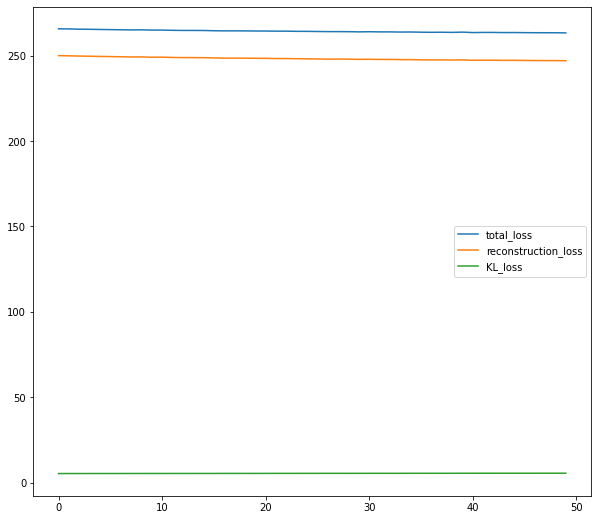

In [ ]:
plt.figure(figsize=(10,9))
plt.plot(history.history.get('total_loss'), label='total_loss')
plt.plot(history.history.get('ce_loss'), label='reconstruction_loss')
plt.plot(history.history.get('kl_loss'), label='KL_loss')
plt.legend()

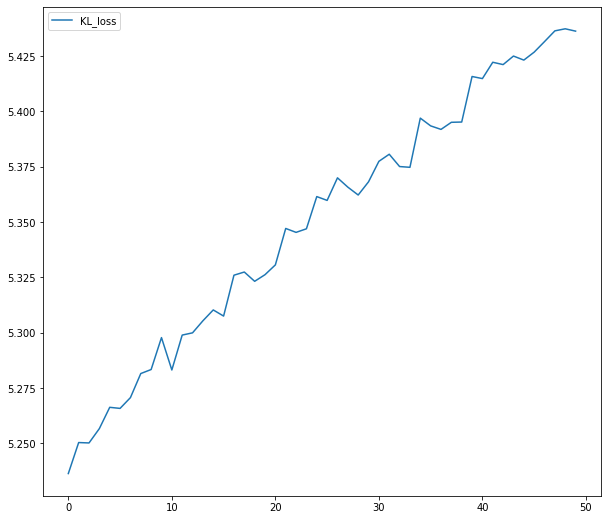

In [ ]:
plt.figure(figsize=(10,9))
plt.plot(history.history.get('kl_loss'), label='KL_loss')
plt.legend()

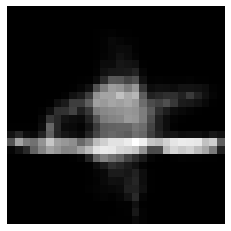

In [ ]:
# Explore the result
synth = vae.decoder.predict([[1,2]]) # mean of 1 and standard deviation of 2
plt.axis('off')
plt.imshow(synth.reshape((28,28)), cmap='Greys_r');

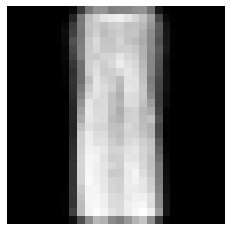

In [ ]:
synth = vae.decoder.predict([[0,1]]) # mean of 1 and standard deviation of 2
plt.axis('off')
plt.imshow(synth.reshape((28,28)), cmap='Greys_r');

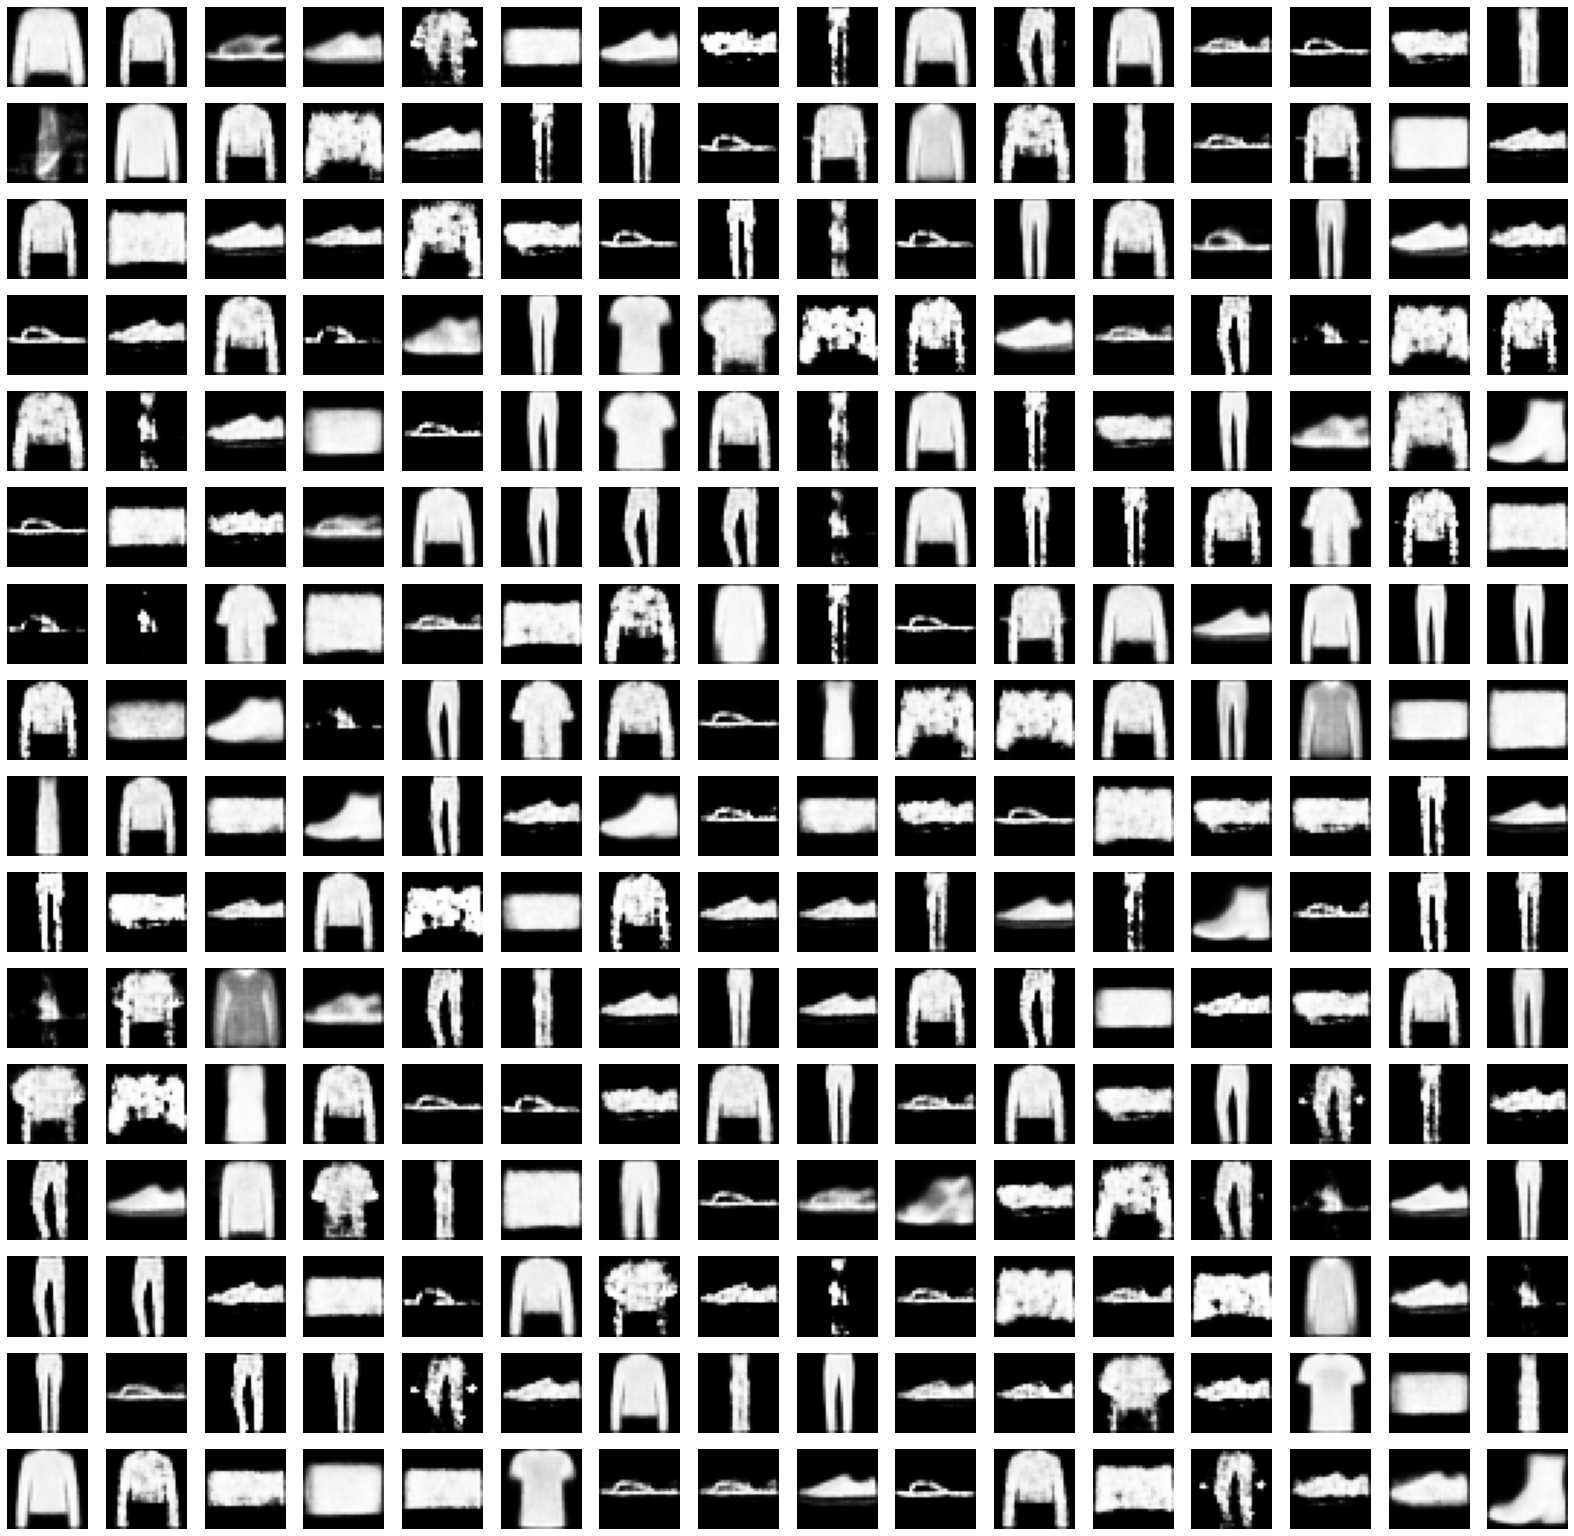

In [ ]:
z = np.random.normal(loc=0, scale=4, size=(256,2))
synth = vae.decoder.predict(z)

plt.figure(figsize=(28,28))

for i in range(256):
  plt.subplot(16,16, i+1)
  plt.imshow(synth[i].reshape((28,28)), cmap='Greys_r')
  plt.axis('off')

plt.show()

In [ ]:
idx = 1280
batch = np.expand_dims(x_train[idx], axis=0)
batchOfImages = np.expand_dims(batch , axis=-1).astype('float32')/355
print(batchOfImages.shape)

# Obtain the z(mu, sigma) for the given image
_, _ , z = vae.encoder.predict(batchOfImages)

synth = vae.decoder.predict([z])

z

(1, 28, 28, 1)


array([[-0.16839924,  0.90801346]], dtype=float32)

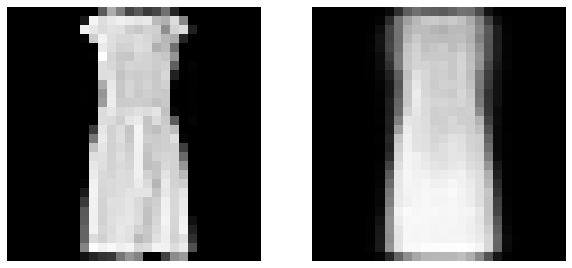

In [ ]:
plt.figure(figsize=(10,10))

#original image
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(x_train[idx], cmap = 'Greys_r')

#Reconstructed
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(synth[0].reshape((28,28)), cmap = 'Greys_r')
plt.show()

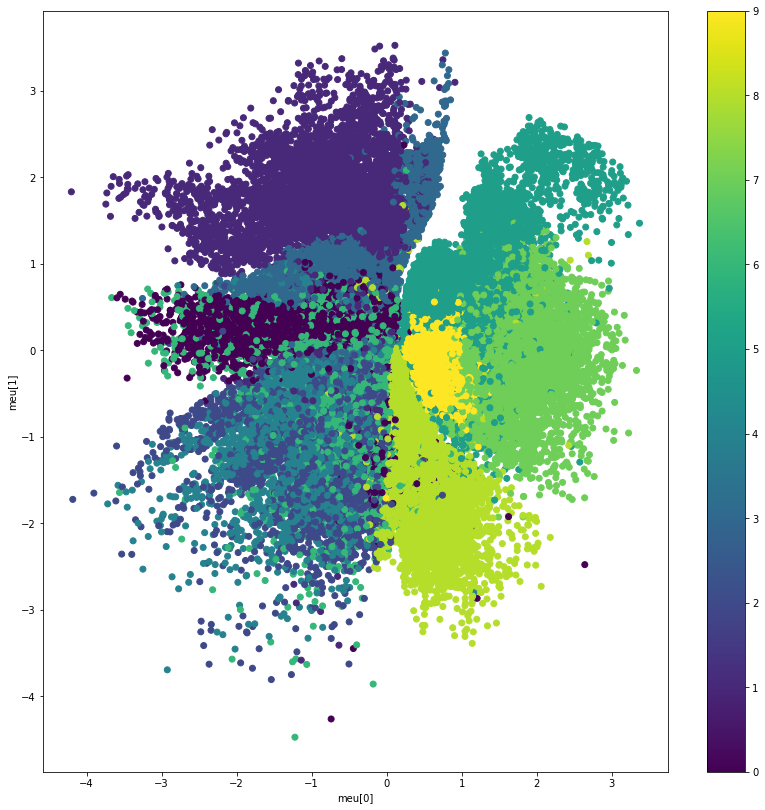

In [ ]:
"""
VAE can be used in unsupervised learning of large text or unlabelled images corpus
to cluster the samples into categories
"""
labels = np.concatenate([y_train, y_test], axis = 0)
meu, _, _ = vae.encoder.predict(dataset)
plt.figure(figsize=(14,14))
plt.scatter(meu[:,0], meu[:,1], c=labels)
plt.colorbar()
plt.xlabel("meu[0]")
plt.ylabel("meu[1]")
plt.show()

In [ ]:
meu[0]

array([ 0.6140943 , -0.18754637], dtype=float32)